# Audio Analysis

In [1]:
# link backend
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append('/home/darkangel/ai-light-show/backend')
from backend.config import SONGS_TEMP_DIR, SONGS_DIR

# sample song 
song_name = 'Queen of Kings - Alessandra'
song_file = f"/home/darkangel/ai-light-show/songs/{song_name}.mp3"
print(f"song: {song_name} | {song_file}")

song: Queen of Kings - Alessandra | /home/darkangel/ai-light-show/songs/Queen of Kings - Alessandra.mp3


In [2]:
from backend.ai.demucs_split import extract_stems
stems_folder = extract_stems(song_file)

drums_path = f"{stems_folder['output_folder']}/drums.wav"

Important: the default model was recently changed to `htdemucs` the latest Hybrid Transformer Demucs model. In some cases, this model can actually perform worse than previous models. To get back the old default model use `-n mdx_extra_q`.
Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in /home/darkangel/ai-light-show/songs/temp/htdemucs
Separating track /home/darkangel/ai-light-show/songs/Queen of Kings - Alessandra.mp3



In [3]:
print(f"drums: {drums_path}")
import librosa
import numpy as np

y, sr = librosa.load(drums_path, sr=None)
y = y / np.max(np.abs(y))  # peak normalize

drums: /home/darkangel/ai-light-show/songs/temp/htdemucs/Queen of Kings - Alessandra/drums.wav


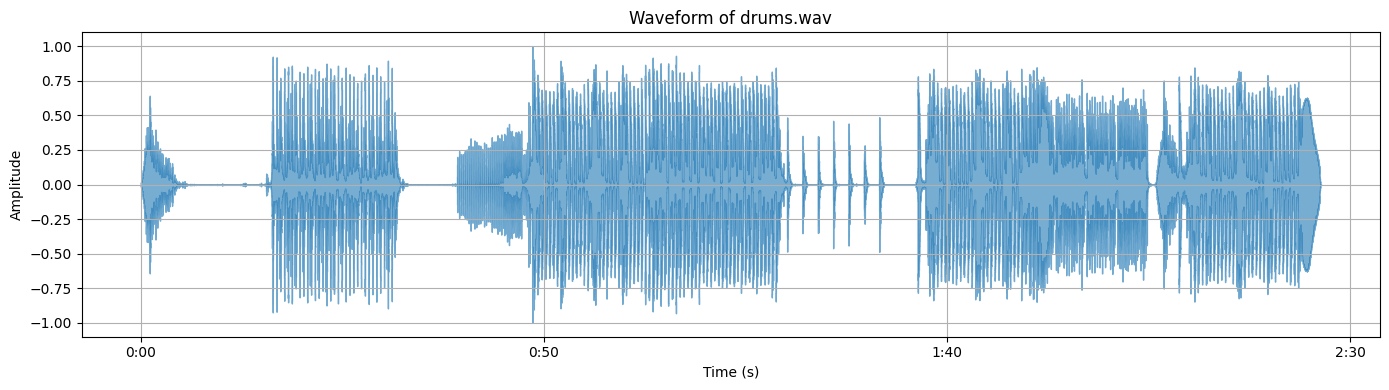

In [4]:
!pip install matplotlib --quiet
import matplotlib.pyplot as plt
import numpy as np

# 🔍 Plot waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.title("Waveform of drums.wav")
plt.xlabel("Time (s)")

num_points = len(y)
times = np.linspace(0, num_points / sr, num_points)
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
S = librosa.stft(y, n_fft=2048, hop_length=512)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

In [9]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import torch, librosa, numpy as np

model_name = "yojul/wav2vec2-base-one-shot-hip-hop-drums-clf"
feat = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name)

y, sr = librosa.load(drums_path, sr=16000, mono=True)
window, hop = int(0.1*sr), int(0.05*sr)
events = []

for start in range(0, len(y)-window, hop):
    chunk = y[start:start+window]
    inputs = feat(chunk, sampling_rate=sr, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1).squeeze().cpu().numpy()
    label = model.config.id2label[np.argmax(probs)]
    conf = float(np.max(probs))
    if conf > 0.6:  # tune down if needed
        events.append({"time": (start+window/2)/sr, "type": label, "confidence": conf})

print(events[:10])


[{'time': 0.05, 'type': 'CYMBALS', 'confidence': 0.9486346244812012}, {'time': 0.1, 'type': 'CYMBALS', 'confidence': 0.9605631828308105}, {'time': 0.15, 'type': 'CYMBALS', 'confidence': 0.9241117835044861}, {'time': 0.2, 'type': 'CYMBALS', 'confidence': 0.9552940726280212}, {'time': 0.25, 'type': 'CYMBALS', 'confidence': 0.927483320236206}, {'time': 0.3, 'type': 'CYMBALS', 'confidence': 0.9436581134796143}, {'time': 0.35, 'type': 'CYMBALS', 'confidence': 0.9630992412567139}, {'time': 0.4, 'type': 'CYMBALS', 'confidence': 0.9523106217384338}, {'time': 0.45, 'type': 'CYMBALS', 'confidence': 0.8382669687271118}, {'time': 0.5, 'type': 'CYMBALS', 'confidence': 0.9154618978500366}]


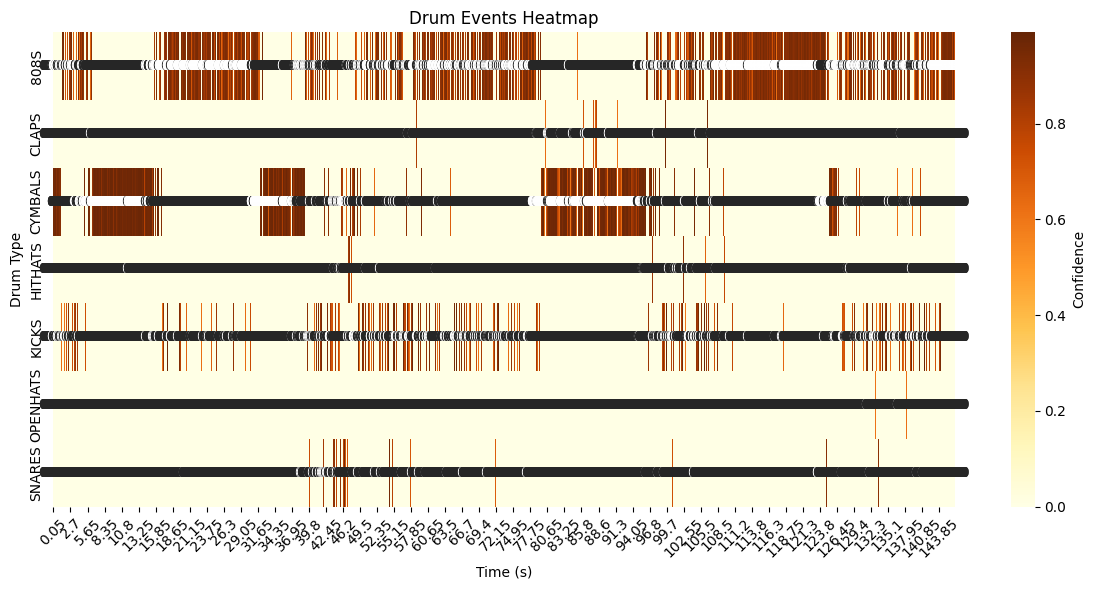

In [14]:
!pip install seaborn --quiet
import numpy as np
import pandas as pd

# Convert events to a DataFrame
df = pd.DataFrame(events)
pivot_df = df.pivot_table(index="type", columns="time", values="confidence", aggfunc="max", fill_value=0)
pivot_df

# Plot the heatmap
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, cmap="YlOrBr", annot=True, fmt=".2f", cbar_kws={'label': 'Confidence'})
plt.title("Drum Events Heatmap")
plt.xlabel("Time (s)")
plt.ylabel("Drum Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Install necessary packages and clone the repository
!pip install tensorflow keras --quiet
!git clone https://github.com/aabalke33/drum-audio-classifier.git
!echo $PWD

In [ ]:
# 🥁 aabalke33 Drum Detection (Keras 3 compatible)
!pip install -q tensorflow librosa matplotlib soundfile

# Clone model if needed
import os
if not os.path.exists("drum-audio-classifier"):
    !git clone https://github.com/aabalke33/drum-audio-classifier.git

import librosa, numpy as np, json, tensorflow as tf
from keras.layers import TFSMLayer

# Load model using TFSMLayer
model_path = "drum-audio-classifier/saved_model/model_20230607_02"
layer = TFSMLayer(model_path, call_endpoint="serving_default")
class_names = ['Clap', 'Closed_Hi-Hat', 'Kick', 'Open_Hi-Hat', 'Snare']

# Load audio
y, sr = librosa.load("drums.wav", sr=16000, mono=True)
window, hop = int(0.1 * sr), int(0.05 * sr)
events = []

# Detect events using sliding window + spectrogram
for start in range(0, len(y) - window, hop):
    chunk = y[start:start+window]
    mel = librosa.feature.melspectrogram(chunk, sr=sr, n_mels=128, fmax=8000)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = np.stack([mel_db]*3, axis=-1)
    mel_db = tf.image.resize(mel_db, (128, 128))
    mel_db = tf.expand_dims(mel_db, axis=0)

    pred = layer(mel_db)[0].numpy()
    label = class_names[np.argmax(pred)]
    conf = float(np.max(pred))
    if conf > 0.5:
        events.append({"time": (start + window/2) / sr, "type": label, "confidence": conf})

# Save results
with open("aabalke_events.json", "w") as f:
    json.dump(events, f, indent=2)

print(f"✅ Saved aabalke_events.json with {len(events)} events")


ValueError: File format not supported: filepath=drum-audio-classifier/saved_model/model_20230607_02. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(drum-audio-classifier/saved_model/model_20230607_02, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

## Use pretzel-ai/drum-transcription

In [7]:
!pip install torch transformers flax jax librosa soundfile --quiet


# load model and tokenizer
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import torch, librosa, numpy as np

model_name = "DunnBC22/wav2vec2-base-Drum_Kit_Sounds"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name)

# Load drums.wav
y, sr = librosa.load(drums_path, sr=16000, mono=True)
y = y / np.max(np.abs(y))  # peak normalize

window = int(0.1 * sr)
hop = int(0.05 * sr)

events = []
for start in range(0, len(y) - window, hop):
    chunk = y[start:start+window]
    inputs = feature_extractor(chunk, sampling_rate=sr, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1).squeeze().cpu().numpy()
    label = model.config.id2label[np.argmax(probs)]
    confidence = float(np.max(probs))

    if confidence > 0.3:
        time_sec = (start + window/2) / sr
        events.append({"time": time_sec, "type": label, "confidence": confidence})


0.05s: overheads (0.36)
0.10s: overheads (0.31)
0.15s: overheads (0.32)
0.20s: overheads (0.39)
0.25s: snare (0.31)
0.35s: toms (0.33)
0.40s: toms (0.32)
0.45s: toms (0.34)
0.60s: toms (0.35)
0.70s: toms (0.34)
0.80s: overheads (0.30)
0.85s: overheads (0.31)
0.90s: toms (0.30)
0.95s: overheads (0.32)
1.15s: toms (0.31)
1.25s: toms (0.36)
1.30s: toms (0.37)
1.35s: toms (0.37)
1.40s: toms (0.36)
1.45s: toms (0.38)
1.55s: toms (0.36)
1.60s: toms (0.39)
1.70s: toms (0.38)
1.75s: toms (0.32)
1.80s: toms (0.35)
1.85s: toms (0.39)
1.90s: toms (0.38)
1.95s: toms (0.35)
2.05s: toms (0.40)
2.40s: toms (0.31)
2.55s: toms (0.38)
2.60s: toms (0.38)
2.75s: toms (0.33)
2.80s: toms (0.35)
2.85s: toms (0.33)
2.90s: toms (0.39)
2.95s: toms (0.31)
3.30s: overheads (0.30)
3.35s: toms (0.39)
3.45s: toms (0.36)
3.70s: toms (0.38)
3.75s: toms (0.39)
3.85s: toms (0.39)
3.90s: toms (0.39)
3.95s: toms (0.32)
4.00s: toms (0.33)
4.10s: toms (0.37)
4.30s: toms (0.33)
4.40s: toms (0.36)
4.45s: toms (0.39)
4.55s: to

In [8]:
import pandas as pd
df = pd.DataFrame(events)
df = df.sort_values(by='time').reset_index(drop=True)
df

,time,type,confidence
0,0.05,overheads,0.355038
1,0.10,overheads,0.309118
2,0.15,overheads,0.323047
3,0.20,overheads,0.394719
4,0.25,snare,0.311323
...,...,...,...
1677,146.15,toms,0.346783
1678,146.20,toms,0.325495
1679,146.25,toms,0.324844
1680,146.30,toms,0.333214


In [ ]:
# Grab a single random 1-second chunk
test_chunk = y[sr * 44:sr * 46]  # 10s to 11s
inputs = feature_extractor(test_chunk, sampling_rate=sr, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

probs = torch.softmax(logits, dim=-1).squeeze().cpu().numpy()
top_idx = np.argmax(probs)
label = model.config.id2label[top_idx]
confidence = float(probs[top_idx])

print(f"Predicted label: {label}, confidence: {confidence:.3f}")

for idx, prob in enumerate(probs):
    label = model.config.id2label[idx]
    print(f"{label}: {prob:.3f}")